In [12]:
# Load package
suppressWarnings(suppressPackageStartupMessages({
    library(Seurat)
    library(ggplot2)
    library(dplyr) 
    library(scCustomize)
    library(clusterProfiler)
    library(org.Mm.eg.db)
    library(msigdbr)
    library(CellChat)
    library(patchwork)
    library(tibble) 
    library(ggplot2)
library(ggrepel)
    library(openxlsx)
}))

## Figure S2G

In [2]:
data_dir = "/scratch/gpfs/KANG/hirak/Princeton/cell_paper/data_files"

In [3]:
mycolors3 = c("#418abd","#ADC6E6","#98DF89","#2FA12E","#2a661d",
              "#8E8E8E","#e3c702","#A2DBE5","#BDBC23","#956ABE",
              "#34BECF", "#C7C7C7","#C5B1D6","#F97F10", "#FBBE7F",
              "#E67D7E","#FBC1C2","#DCC3BF","#BA9994","#E276C2","#F7B8D3")

# Fig size setting
fig.size <- function (height, width) {
    options(repr.plot.height = height, repr.plot.width = width)
}

In [4]:
# Load integrated data
combined<-readRDS( file =glue::glue(data_dir,"/niche_normal_distal_integrated_umap.rds"))
# Rename cell type
combined.renamed <- RenameIdents(object = combined, 
                               "0" = "Neutrophils_d",
                               "1" = "Neutrophils_a",
                               "2" = "Neutrophils_c",
                               "3" = "Immature B cells",
                               "4" = "Macrophages_a",
                               "5" = "Neutrophils_e",
                               "6" = "Neutrophil progenitors",
                               "7" = "Neutrophils_b",
                               "8" = "GMPs",
                               "9" = "T cells_a",
                               "10" = "Macrophages_b",
                               "11" = "T cells_b",
                               "12" = "DCs",
                               "13" = "Macrophages_c",
                               "14" = "Erythroblasts",
                               "15" = "Neutrophils_f",
                               "16" = "Pre-B cells",
                               "17" = "MEPs", 
                               "18" = "Basophils",
                               "19" = "Pro-B cells", 
                               "20" = "CLPs")
my_levels <-  c("T cells_b","T cells_a",
                "Immature B cells","Pre-B cells","Pro-B cells","CLPs",
                "Erythroblasts","MEPs",
                "DCs","Macrophages_c","Macrophages_b","Macrophages_a","GMPs",
                "Neutrophil progenitors",
                "Neutrophils_a","Neutrophils_b","Neutrophils_c",
                "Neutrophils_d","Neutrophils_e","Neutrophils_f",
                "Basophils")
Idents(combined.renamed) <- factor(Idents(combined.renamed), 
                                   levels= my_levels)
combined.renamed@meta.data$cluster_names = Idents(combined.renamed)

In [5]:
gene_signatures <- list(
  Pro_1 = c("Tnf", "Il1a", "Il1b", "Il6", "Il12a", "Il12b", "Il18", "Il23a"),
  Anti_1 = c("Il10", "Tgfb1", "Tgfb2", "Tgfb3", "Il6"),
  
  Pro_2 = c("Tnf", "Il1b", "Il6"),
  Anti_2 = c("Tgfb1", "Tgfb2", "Tgfb3", "Il10", "Ptgs2"),
  
  Pro_3 = c("Il1b", "Tnf", "Il12a", "Il12b", "Il6"),
  Anti_3 = c("Il10", "Tgfb1", "Tgfb2", "Tgfb3")
)


#all_cyto = "^Cxcl", "^Il", "^Tgf" 

In [6]:
DefaultAssay(combined.renamed) = "RNA"
mac <- subset(x = combined.renamed, 
                     idents = c('Macrophages_a','Macrophages_b','Macrophages_c'))

Warning message:
“Scaling data with a low number of groups may produce misleading results”


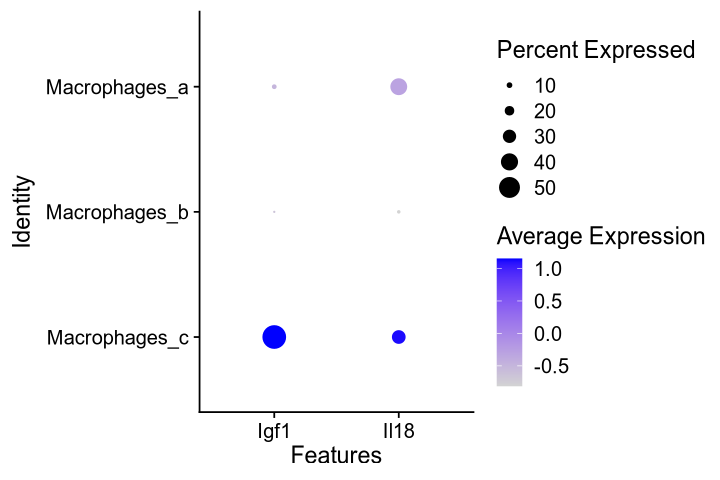

In [7]:
fig.size(4,6)
DotPlot(
    mac,features = c('Igf1','Il18')
)

### Find out pseudo bulk

In [8]:
pb_expr <- AverageExpression(mac, 
                             group.by = "cluster_names")$RNA 

As of Seurat v5, we recommend using AggregateExpression to perform pseudo-bulk analysis.
This message is displayed once per session.
Names of identity class contain underscores ('_'), replacing with dashes ('-')
This message is displayed once every 8 hours.


In [9]:
pb_expr %>% colnames

[1] "Macrophages-c" "Macrophages-b" "Macrophages-a"

In [10]:
colnames(pb_expr) <- c("Mac_c", "Mac_b", "Mac_a")

In [11]:
pb_log <- log1p(pb_expr)
pb_log = pb_log %>%
  as.data.frame()

In [13]:
cyto_df = read.xlsx("../Full_cytokines_growth_factor_list.xlsx")
cytokines = cyto_df$Ligand %>% unique

In [14]:
scatter_data <- pb_log %>%
  rownames_to_column("Gene") %>%
  mutate(label = ifelse(Gene %in% cytokines, Gene, NA))


### Plot

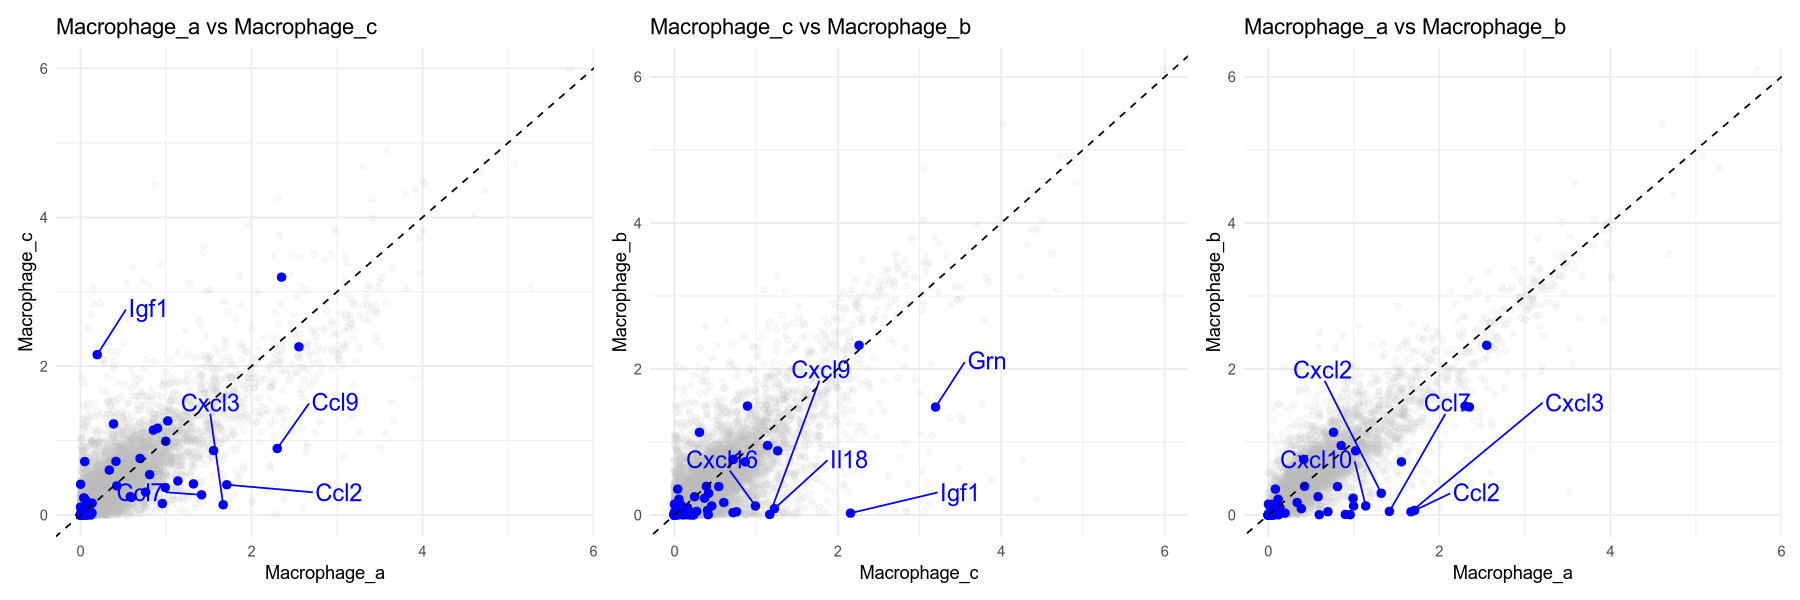

In [22]:
fig.size(5,15)
top_n = 5
top5_ca <- scatter_data %>%
  filter(Gene %in% cytokines) %>%
  mutate(diff = abs(Mac_c - Mac_a)) %>%
  slice_max(diff, n = top_n)

top5_cb <- scatter_data %>%
  filter(Gene %in% cytokines) %>%
  mutate(diff = abs(Mac_c - Mac_b)) %>%
  slice_max(diff, n = top_n)

top5_ab <- scatter_data %>%
  filter(Gene %in% cytokines) %>%
  mutate(diff = abs(Mac_a - Mac_b)) %>%
  slice_max(diff, n = top_n)



p1 <- ggplot(scatter_data, aes(x = Mac_a, y = Mac_c)) +
  geom_point(color='grey', alpha = 0.1) +  # All genes in grey
  geom_point(data = filter(scatter_data, Gene %in% cytokines),
             aes(x = Mac_a, y = Mac_c),
             color = "blue", size = 2) +    # Cytokines in blue
  geom_text_repel(data = top5_ca,
                  aes(label = Gene),
                  color = "blue", 
                  box.padding = 1.5,        # Much larger padding around text boxes
                    point.padding = 0,      # Much larger padding around points
                    min.segment.length = 0,   # Always show segments
                  size = 5,
                  max.overlaps=Inf
                 ) +
  labs(title = "Macrophage_a vs Macrophage_c", x = "Macrophage_a", y = "Macrophage_c") +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "black") +
  theme_minimal()

p2 <- ggplot(scatter_data, aes(x = Mac_c, y = Mac_b)) +
  geom_point(color = "grey", alpha = 0.1) +
  geom_point(data = filter(scatter_data, Gene %in% cytokines),
             aes(x = Mac_c, y = Mac_b),
             color = "blue", size = 2) +
   geom_text_repel(data = top5_cb,
                  aes(label = Gene),
                  color = "blue", 
                  box.padding = 1.5,        # Much larger padding around text boxes
                    point.padding = 0,      # Much larger padding around points
                    min.segment.length = 0,   # Always show segments
                  size = 5,
                  max.overlaps=Inf
                 ) +
  labs(title = "Macrophage_c vs Macrophage_b", x = "Macrophage_c", y = "Macrophage_b") +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "black") +
  theme_minimal()

p3 <- ggplot(scatter_data, aes(x = Mac_a, y = Mac_b)) +
  geom_point(color = "grey", alpha = 0.1) +
  geom_point(data = filter(scatter_data, Gene %in% cytokines),
             aes(x = Mac_a, y = Mac_b),
             color = "blue", size = 2) +
  geom_text_repel(data = top5_ab,
                  aes(label = Gene),
                  color = "blue", 
                  box.padding = 1.5,        # Much larger padding around text boxes
                    point.padding = 0,      # Much larger padding around points
                    min.segment.length = 0,   # Always show segments
                  size = 5,
                  max.overlaps=Inf
                 ) +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "black") +  
  labs(title = "Macrophage_a vs Macrophage_b", x = "Macrophage_a", y = "Macrophage_b") +
  theme_minimal()

combined_plot <- p1 + p2 + p3 + plot_layout(nrow = 1)
combined_plot


## Figure S4J

In [24]:
bm_3_eri = readRDS('../niche_normal_distal_erythroblast.rds')

In [25]:
cc.genes.mm = readRDS('~/cc.genes.mm.rds')
s.genes = cc.genes.mm$s.genes
g2m.genes = cc.genes.mm$g2m.genes

In [26]:
bm_3_eri = CellCycleScoring(
    bm_3_eri, s.features = s.genes, 
    g2m.features = g2m.genes, set.ident = TRUE
)

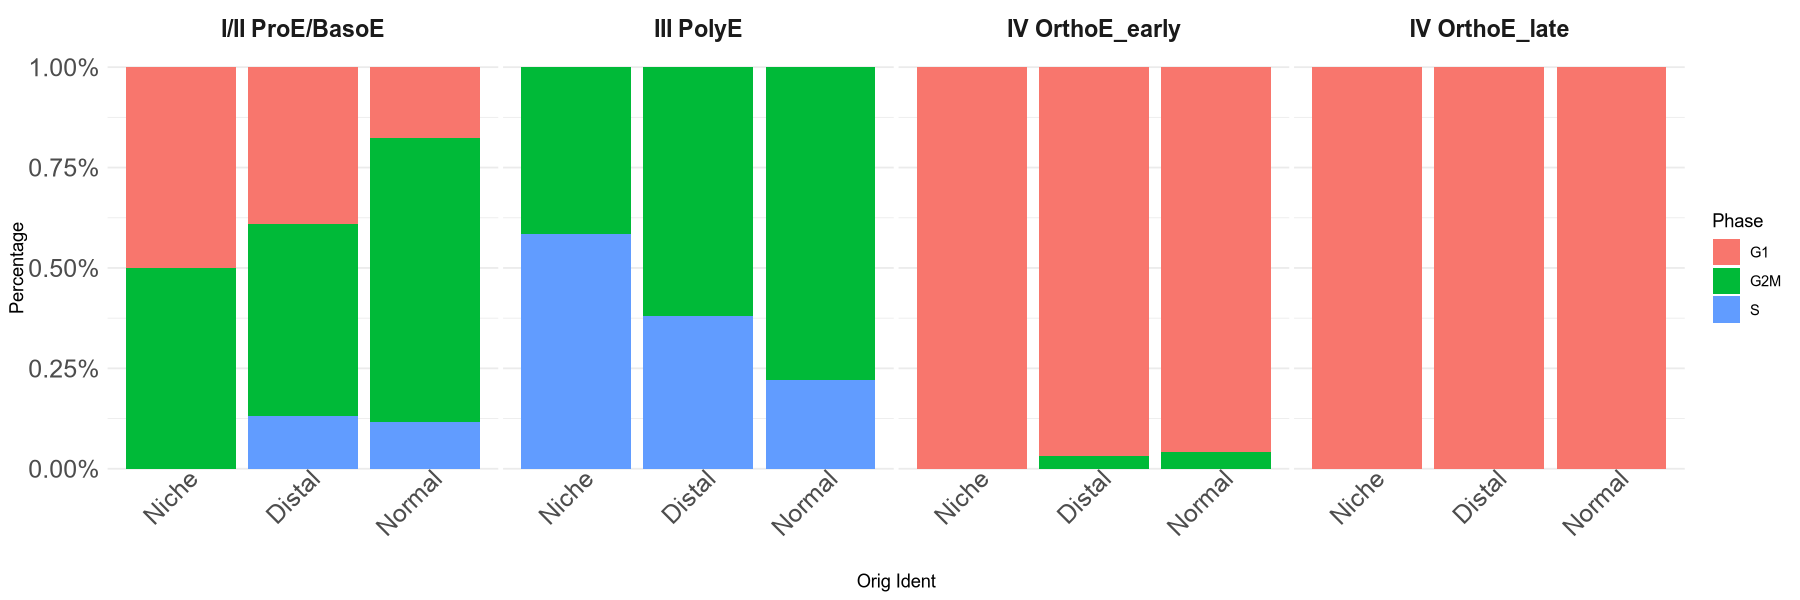

In [34]:


# Summarize counts and compute percentages within each `orig.ident` and `old.ident`
desired_order <- c("Niche", "Distal", "Normal")  # Adjust as needed

# Summarize counts and compute percentages within each `orig.ident` and `old.ident`
phase_counts <- bm_3_eri@meta.data %>%
  group_by(orig.ident, old.ident, Phase) %>%
  tally() %>%
  group_by(orig.ident, old.ident) %>%
  mutate(percent = (n / sum(n)) * 100) %>% 
  mutate(orig.ident = factor(orig.ident, levels = desired_order))
# phase_counts <- bm_3_eri@meta.data %>%
#   group_by(orig.ident, old.ident, Phase) %>%
#   tally() %>%
#   group_by(orig.ident, old.ident) %>%
#   mutate(percent = (n / sum(n)) * 100)  # Normalize within each `orig.ident` and `old.ident`

# Plot grouped stacked bar chart (single row for facets)
ggplot(phase_counts, aes(x = orig.ident, y = percent, fill = Phase)) +
  geom_bar(stat = "identity", position = "fill") +  # Ensure equal bar heights (100%)
  facet_grid(~ old.ident, space = "free_x", scales = "free_x") +  # Keep all facets in a single row
  theme_minimal() +
  labs(x = "Orig Ident", y = "Percentage", fill = "Phase") +
  scale_y_continuous(labels = scales::percent_format(scale = 1)) +  # Ensure y-axis is in percentage
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1,vjust=1.5,size=15),  
    axis.text.y = element_text(size=15), 
    strip.text = element_text(size = 14, face = "bold"), 
    panel.grid.major.x = element_blank(),  # Remove vertical gridlines for clarity
    panel.spacing = unit(0.2, "lines")  # Reduce space between facets
  )


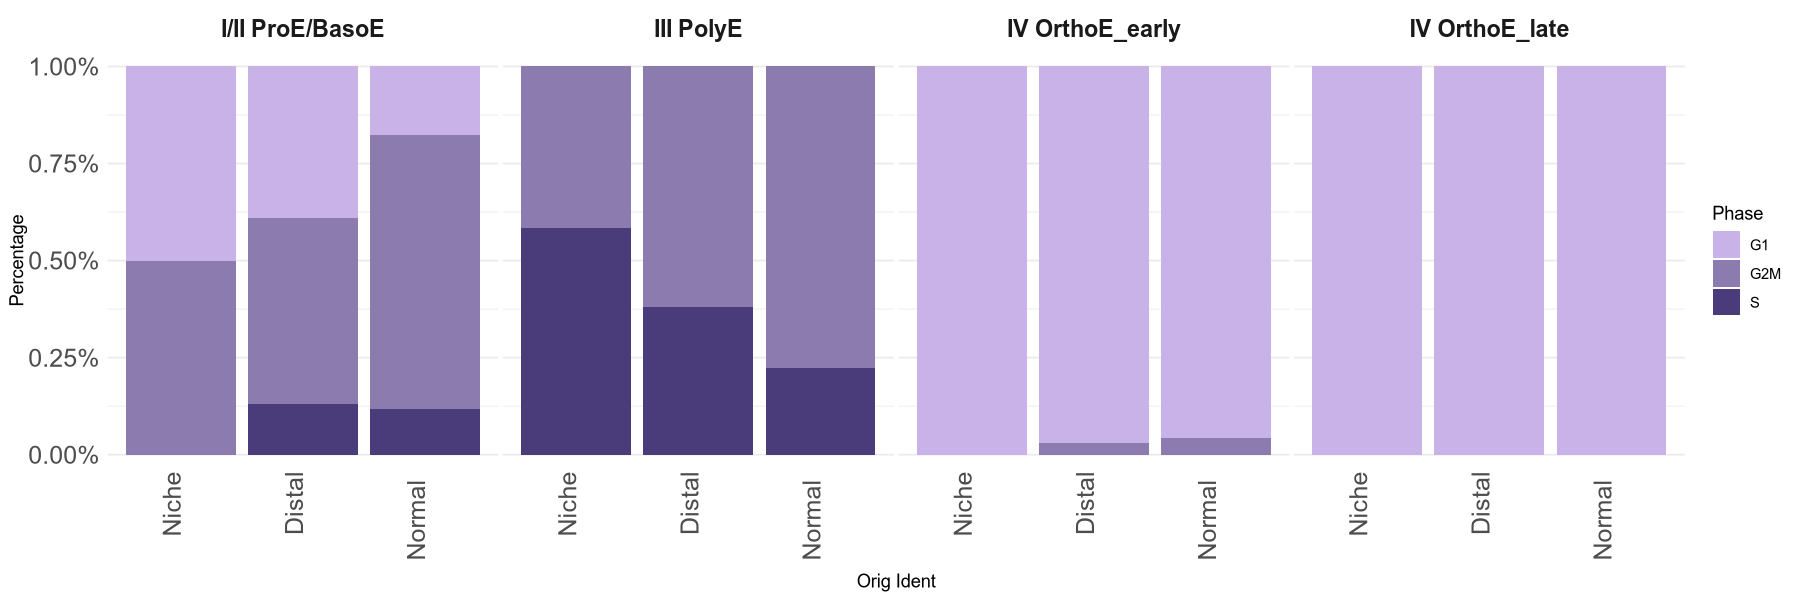

In [50]:
# Summarize counts and compute percentages within each `orig.ident` and `old.ident`
desired_order <- c("Niche", "Distal", "Normal")  # Adjust as needed

# Summarize counts and compute percentages within each `orig.ident` and `old.ident`
phase_counts <- bm_3_eri@meta.data %>%
  group_by(orig.ident, old.ident, Phase) %>%
  tally() %>%
  group_by(orig.ident, old.ident) %>%
  mutate(percent = (n / sum(n)) * 100) %>% 
  mutate(orig.ident = factor(orig.ident, levels = desired_order))

# Define colors to match the image
phase_colors <- c(
  "G1" = "#C8B2E8",      # Light purple
  "G2M" = "#8B7BAF",    # Medium purple  
  "S" = "#4A3B7A",       # Dark purple
  "Niche" = "#E8A4A4",   # Light red/pink
  "Distal" = "#A4C8E8",  # Light blue
  "Normal" = "#A8A8A8"   # Gray
)

# Plot grouped stacked bar chart (single row for facets)
ggplot(phase_counts, aes(x = orig.ident, y = percent, fill = Phase)) +
  geom_bar(stat = "identity", position = "fill") +  # Ensure equal bar heights (100%)
  facet_grid(~ old.ident, space = "free_x", scales = "free_x") +  # Keep all facets in a single row
  
  # Add the custom color scale
  scale_fill_manual(values = phase_colors) +
  
  theme_minimal() +
  labs(x = "Orig Ident", y = "Percentage", fill = "Phase") +
  scale_y_continuous(labels = scales::percent_format(scale = 1)) +  # Ensure y-axis is in percentage
  theme(
    #axis.text.x = element_text(angle = 45, hjust = 1,vjust=1.5),  
    axis.text.x = element_text(angle = 90, hjust = 1.5,vjust=0,size=15),  
    axis.text.y = element_text(size=15), 
    strip.text = element_text(size = 14, face = "bold"), 
    panel.grid.major.x = element_blank(),  # Remove vertical gridlines for clarity
    panel.spacing = unit(0.2, "lines")  # Reduce space between facets
  )